### Modules

In [1]:
# basic
import os, sys, glob
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc, silhouette_samples

### Figure S11

In [2]:
def get_precision(y_true, y_pred):
    
    confusion = confusion_matrix(y_true, y_pred)

    TP = confusion[1,1]
    FP = confusion[0,1]
    TN = confusion[0,0]
    FN = confusion[1,0]

    FPR = FP/(FP+TN)
    TPR = TP/(TP+FN)
    precision = round(TP/(TP+FP), 2)
    
    return precision

#### IVT

In [3]:
pred_pos =  pd.read_csv('../data/ivtmix20_valid.csv', index_col = 0)
pred_neg = pd.read_csv('../data/ivtmix0_valid.csv', index_col = 0)

pred_table = pd.concat([pred_pos, pred_neg], axis = 0)

### precision
y_pred = [1 if i>=0.5 else 0 for i in pred_table['probability']]
y_true = [1]*pred_pos.shape[0]+[0]*pred_neg.shape[0]

precision_ivt_low  = get_precision(y_true, y_pred)

y_pred = [1 if i>=0.9 else 0 for i in pred_table['probability']]
y_true = [1]*pred_pos.shape[0]+[0]*pred_neg.shape[0]

precision_ivt_high  = get_precision(y_true, y_pred)

#### HEK293

In [4]:
### ground-truth m6A sites from m6A-SAC-seq
gt_table = pd.read_csv('../data/gt_sac_hek293.csv', index_col = 0)
gt_sites = sorted([x+'_'+str(y) for x,y in zip(gt_table['chr'], gt_table['center'])])

# remove m6A sites also reported by miCLIP-seq and keep the pool of m6A-negative sites more confident
gt_table_u = pd.read_csv('../data/gt_usites_hek293.csv', index_col = 0)
gt_sites_u = sorted([x+'_'+str(y) for x,y in zip(gt_table_u['chr'], gt_table_u['center'])])
coverage = 50

# m6ATM
pred = pd.read_csv('../data/hek293_m6atm.csv', index_col = 0)
pred = pred[pred.coverage>=coverage]
pred['gt'] = pred['gn_site'].isin(gt_sites)

pred_pos = pred[pred['gt'] == True]
pred_gt_n = pred[pred['gt'] == False]
pred_gt_not_u = pred_gt_n[~pred_gt_n['gn_site'].isin(gt_sites_u)]
pred_neg = pred_gt_not_u.sample(n = pred[pred['gt'] == True].shape[0], random_state = 0)

pred_all = pd.concat([pred_pos, pred_neg], axis = 0)

### precision
y_pred = [1 if i>=0.5 else 0 for i in pred_all['probability']]
y_true = pred_all['gt']

precision_hek_low  = get_precision(y_true, y_pred)

y_pred = [1 if i>=0.9 else 0 for i in pred_all['probability']]
y_true = pred_all['gt']

precision_hek_high  = get_precision(y_true, y_pred)

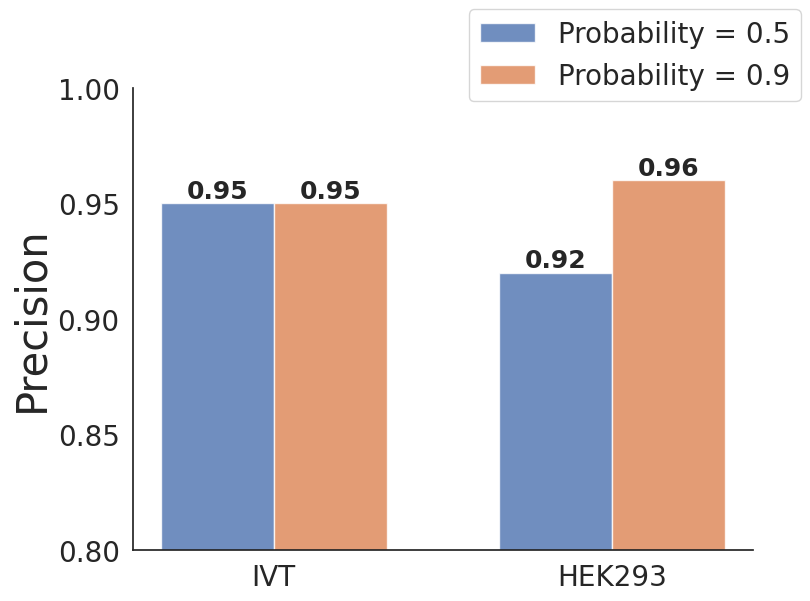

In [5]:
# data
precision_low = [precision_ivt_low, precision_hek_low]
precision_high = [precision_ivt_high, precision_hek_high]

# plot
sns.set_theme(style = 'white') # theme
tab_color = sns.color_palette() # color palette
fig, ax = plt.subplots(figsize = (8, 6)) # figure size

x = np.array([0.85, 1.15])  # the label locations
width = 0.1  # the width of the bars

rects1 = ax.bar(x-0.05, precision_low, width, label = 'IVT-20%', alpha = 0.8)
rects2 = ax.bar(x+0.05, precision_high, width, label = 'HEK293', alpha = 0.8)

plt.xticks(x, ['IVT', 'HEK293'])
plt.yticks(np.arange(0.8, 1.1, 0.05))
plt.legend(labels  = ['Probability = 0.5', 'Probability = 0.9'],
           fontsize = 20, loc = 'upper right', bbox_to_anchor = (1.1, 1.2))

plt.ylabel('Precision', fontsize = 30)  

ax.bar_label(rects1, fmt = '%.2f', label_type = 'edge', fontsize = 18, weight = 'bold')
ax.bar_label(rects2, fmt = '%.2f', label_type = 'edge', fontsize = 18, weight = 'bold')

ax.set(ylim = (0.8, 1.0))
ax.tick_params(labelsize = 20)
sns.despine()